<h1>Climate Weather Analysis</h1>

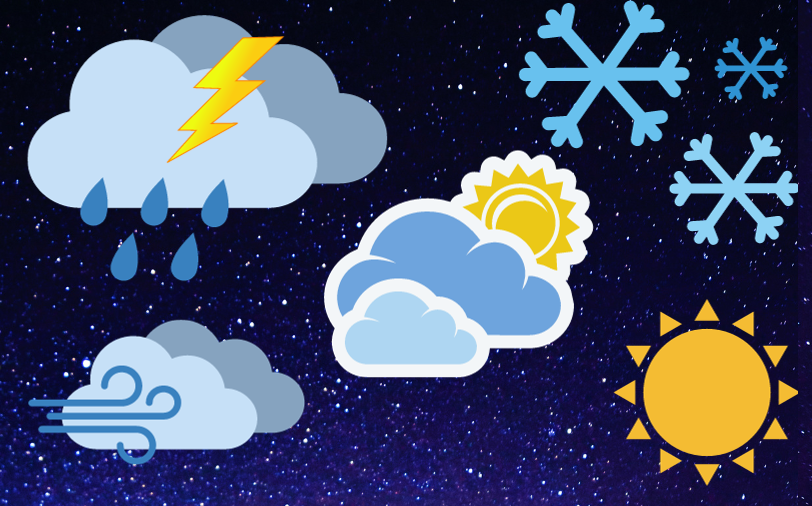

## Downloading Kaggle Dataset

Kaggle API Token(kaggle.json) to download the Weather Datasets

More details on Kaggle API can be found
https://github.com/Kaggle/kaggle-api

Climate data

[The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data?select=cities.csv) - 3 files

[US Weather Events (2016 - 2022)](https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events)

## Import Modules

In [ ]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from scipy import signal

In [ ]:
from pandas.plotting import lag_plot

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

## Read Files - 2 datasets - 4 files - 3 CSVs - 1 parquet

In [ ]:
# dataset 1 - CSV
countries_data = pd.read_csv('/kaggle/input/global-daily-climate-data/countries.csv')
gbl_cities_data = pd.read_csv('/kaggle/input/global-daily-climate-data/cities.csv')

In [ ]:
# dataset 1 - parquet file
gbl_weather_data = pd.read_parquet('/kaggle/input/global-daily-climate-data/daily_weather.parquet')

In [ ]:
# dataset 2 - CSV file US Weather based events (48 states)
us_event_data = pd.read_csv('/kaggle/input/us-weather-events/WeatherEvents_Jan2016-Dec2022.csv')

# Explore and Transform

In [ ]:
# display data
print(f"---countries data---\n{countries_data.sample(3)}")   # display random 3 rows to view data
print(f"\n---cities data---\n{gbl_cities_data.sample(3)}")   # display random 3 rows to view data

<h2>Cities and Countries data<//h2>

In [ ]:
# Review columns that include missing values from the different dataframes
print("Columns with missing values: ")
print("\n---countries data---")
print(countries_data.columns[countries_data.isnull().any()].tolist())
print("\n---cities data---")
print(gbl_cities_data.columns[gbl_cities_data.isnull().any()].tolist())

In [ ]:
# Display missing values per column for countries and cities dataframes
print("\n---countries data---")
print(countries_data.isnull().sum())
print("\n---cities data---")
print(gbl_cities_data.isnull().sum())

## Drop columns countries and (global) cities dataframes

In [ ]:
# Copy dataframe to leave raw table in original state
countries_data_mod = countries_data.copy()

In [ ]:
# drop columns and display remaining column names
countries_data_mod.drop(["native_name", "iso2", "capital_lat", "capital_lng"], axis=1, inplace=True)
countries_data_mod.columns

In [ ]:
# Copy dataframe to leave raw table in original state
gbl_cities_data_mod = gbl_cities_data.copy()

In [ ]:
# drop columns and display remaining column names
gbl_cities_data_mod.drop(["iso2"], axis=1, inplace=True)
gbl_cities_data_mod.columns

In [ ]:
# display first three rows of the dataframe
countries_data_mod.head(3)

In [ ]:
# display first three rows of the dataframe
gbl_cities_data_mod.head(3)

## Rename Countries to be consistent

In [ ]:
# Compare country column from cities and countries dataframes
print(f"countries df: {countries_data_mod['country'].nunique()}")
print(f"cities df: {gbl_cities_data_mod['country'].nunique()}")

In [ ]:
# Determine which countries are not included or named differently in countries_data_mod
print("cities_data")
list(set(list(gbl_cities_data_mod['country'])) - set(list(countries_data_mod['country'])))

In [ ]:
# Determine which countries are different
list(set(list(countries_data_mod['country'])) - set(list(gbl_cities_data_mod['country'])))

In [ ]:
# Rename countries in cities dataframe to be consistent with countries dataframe
gbl_cities_data_mod = gbl_cities_data_mod.replace(['United States of America', 'Guinea Bissau', 'Svalbard and Jan Mayen Islands', 'Congo (Kinshasa)', 'Macau S.A.R', 'Congo (Brazzaville)'],['United States','Guinea-Bissau','Svalbard and Jan Mayen','Democratic Republic of the Congo','Macau','Republic of the Congo'])


In [ ]:
# Contries included in one dataframe but missing from the other
print(f"countries_data has : {list(set(list(countries_data_mod['country'])) - set(list(gbl_cities_data_mod['country'])))}")
print(f"\ncities_data has : {list(set(list(gbl_cities_data_mod['country'])) - set(list(countries_data_mod['country'])))}")

In [ ]:
# filter out
value = ['Wales']
countries_data_mod = countries_data_mod[countries_data_mod.country.isin(value) == False]

In [ ]:
# filter
values = ['Andorra', 'Montenegro', 'Myanmar']
gbl_cities_data_mod = gbl_cities_data_mod[gbl_cities_data_mod.country.isin(values) == False]

In [ ]:
# Verify the filters were applied
print(f"countries_data has : {list(set(list(countries_data_mod['country'])) - set(list(gbl_cities_data_mod['country'])))}")
print(f"\ncities_data has : {list(set(list(gbl_cities_data_mod['country'])) - set(list(countries_data_mod['country'])))}")

In [ ]:
# check to see if there are inconsistencies in Country Codes
list(set(list(gbl_cities_data_mod['iso3'])) - set(list(countries_data_mod['iso3'])))

In [ ]:
# display first three rows of the dataframe
countries_data_mod.head(3)

In [ ]:
# display first three rows of the dataframe
gbl_cities_data_mod.head(3)

<h2>Global Weather and US Weather Event data</h2>

In [ ]:
# display first three rows of the dataframe
gbl_weather_data.head(3)

## Histogram Global Weather Data Distribution

In [ ]:
gbl_weather_data.hist(figsize=(20,15))
plt.show()

## Filter Weather data to decrease amount of rows read and speed things up

In [ ]:
# Display timeframe of the weather data
gbl_weather_data['date']

In [ ]:
# Display rows and columns
gbl_weather_data.shape

In [ ]:
# Calculating Min and Max DateTimes to review timeframe range
print(f"min date: {gbl_weather_data['date'].min()}")
print(f"max date: {gbl_weather_data['date'].max()}")

## Filter Global Weather By Date

In [ ]:
# Filter dates following a date range from histogram there seems to be more data starting 70's and 80's
# Selected an 80's start date to lessen the amount rows in the dataframe
gweather_subset_date = \
   gbl_weather_data[(gbl_weather_data['date'] >= '1982-01-01 00:00:00') & (gbl_weather_data['date'] < '2023-01-01 00:00:00')]

In [ ]:
# Display rows and columns after filter
gweather_subset_date.shape

## Drop Rows with Null values - Global Weather data

The global weather dataset at this point is too large - by dropping rows with missing values will help decrease the amount of rows in the dataset. In order to later merge with the gbl_cities_data_mod to do some filtering by country.

In [ ]:
# Display columns with null values
print("\n---Weather data---")
print(gweather_subset_date.isnull().sum())

In [ ]:
# Drop rows with NaN values in specific columns
gweather_subset_date.dropna(subset=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm','avg_wind_dir_deg','avg_wind_speed_kmh','peak_wind_gust_kmh','avg_sea_level_pres_hpa','sunshine_total_min'],inplace=True)

In [ ]:
# Display columns with null values
print("\n---Weather data---")
print(gweather_subset_date.isnull().sum())

In [ ]:
# Review columns that include missing values from the different dataframes
print("Columns with missing values: ")
print(gweather_subset_date.columns[gweather_subset_date.isnull().any()].tolist())

In [ ]:
# Display rows and columns after dropping NaN values
gweather_subset_date.shape

<h2>US Weather Event data</h2>

In [ ]:
# Display amount of rows, columns and column names
print(f"\n Rows and columns: {us_event_data.shape}")
print(us_event_data.columns)

## US Weather Event data - Drop columns

In [ ]:
# Display amount of rows, columns
us_event_data.shape

In [ ]:
# display column names
us_event_data.columns

In [ ]:
# drop columns and display remaining column names
us_event_data.drop(["TimeZone", "AirportCode", "City", "County", "ZipCode"], axis=1, inplace=True)
us_event_data.columns

In [ ]:
# Display columns with null values
print("\n---US Weather Events data---")
print(us_event_data.isnull().sum())

In [ ]:
# Review unique values for the Type column
print(us_event_data['Type'].unique())

In [ ]:
# Return the frequency of each distinct row in the Dataframe for specified column
us_event_data["Type"].value_counts()

In [ ]:
# Review unique values for the Severity column
print(us_event_data['Severity'].unique())

In [ ]:
# # Return the frequency of each distinct row in the Dataframe for specified column
us_event_data["Severity"].value_counts()

## US Weather Event data Filter by columns

In [ ]:
# Filter Severity events that are Unknown or Other
w_events = ['UNK', 'Other']
us_event_data_filtered = us_event_data[us_event_data.Severity.isin(w_events) == False]

In [ ]:
# Review unique values for specified column
print(us_event_data_filtered['Severity'].unique())

In [ ]:
# Calculating Start Min and Max DateTimes to review timeframe range
print(f"Start min date: {us_event_data_filtered['StartTime(UTC)'].min()}")
print(f"Start max date: {us_event_data_filtered['StartTime(UTC)'].max()}")

In [ ]:
# Calculating End Min and Max DateTimes to review timeframe range
print(f"End min date: {us_event_data_filtered['EndTime(UTC)'].min()}")
print(f"End max date: {us_event_data_filtered['EndTime(UTC)'].max()}")

## US Weather data Filter by DateTime to minimize row count

In [ ]:
# Filtering data to only the 2020's to reduce the amount of rows
us_event_data_filtered_date = \
   us_event_data_filtered[(us_event_data_filtered['StartTime(UTC)'] >= '2020-01-01 00:00:00') & (us_event_data_filtered['EndTime(UTC)'] < '2023-01-01 00:00:00')]

In [ ]:
# Display filtered dataframe to reduce amount of rows
us_event_data_filtered_date.shape

In [ ]:
# Filter States to include states are not included in the global weather dataset
st_miss_fm_cit_weather = ['ME', 'SD', 'VT', 'DE', 'LA', 'CA', 'TX', 'AR', 'WA', 'FL', 'MS', 'PA', 'KY', 'OR']
us_event_data_filtered_date = us_event_data_filtered_date[us_event_data_filtered_date.State.isin(st_miss_fm_cit_weather) == True]

# previous filtering method
# Filter out States that have value counts less than 50,000
#print(us_event_data_filtered_date["State"].value_counts())
#st_cnt_lt_50k =  ['WV', 'KS', 'ID', 'MT', 'TN', 'ME', 'SD', 'MD', 'NJ', 'NH', 'NM', 'AZ', 'CT', 'VT', 'UT', 'NV', 'RI', 'DE']
#us_event_data_filtered_date = us_event_data_filtered_date[us_event_data_filtered_date.State.isin(st_cnt_lt_50k) == False]

Remaining states that are also included in cities_weather

['WV', 'KS', 'ID', 'MT', 'TN', 'OK', 'MD', 'NJ', 'NH', 'NM', 'AZ', 'CT', 'UT', 'NV', 'RI',  'CO', 'MN', 'WI', 'MI', 'WY', 'MA', 'MO', 'NC', 'SC', 'VA', 'ND',
  'NY', 'OH', 'IA', 'GA', 'NE', 'AL', 'IL', 'IN']

 'West Virginia', 'Kansas', 'Idaho', 'Montana', 'Tennessee', 'Oklahoma', 'Maryland','New Jersey ,'New Hampshire',
 'New Mexico', 'Arizona', 'Connecticut', 'Utah', 'Nevada', 'Rhode Island',
 'Colorado', 'Minnesota', 'Wisconsin', 'Michigan', 'Wyoming', 'Massachusetts', 'Missouri', 'North Carolina',  'South Carolina', 'Virginia', 'North Dakota',
 'New York', 'Ohio', 'Iowa', 'Georgia', 'Nebraska', 'Alabama', 'Illinois', 'Indiana'

 cities_weather includes 'Hawaii', 'District of Columbia' which are not included in us_event_data_filtered_date dataframe



In [ ]:
# add visual for object data
for column in us_event_data_filtered_date.select_dtypes(include='object'):
    if us_event_data_filtered_date[column].nunique() < 100:
        sns.countplot(y=column, data=us_event_data_filtered_date)
        plt.show()

## US Event Wether data Convert datetime from a string to  datetime64

In [ ]:
us_event_data_filtered_date['StartTime(UTC)'] = pd.to_datetime(us_event_data_filtered_date['StartTime(UTC)'])
us_event_data_filtered_date['EndTime(UTC)'] = pd.to_datetime(us_event_data_filtered_date['EndTime(UTC)'])

In [ ]:
# Extract Date from a Pandas Start Datetime Column
us_event_data_filtered_date['StartDate'] = us_event_data_filtered_date['StartTime(UTC)'].dt.date
us_event_data_filtered_date['EndDate'] = us_event_data_filtered_date['EndTime(UTC)'].dt.date

In [ ]:
# Convert datatype
us_event_data_filtered_date['StartDate'] = pd.to_datetime(us_event_data_filtered_date['StartDate'])
us_event_data_filtered_date['EndDate'] = pd.to_datetime(us_event_data_filtered_date['EndDate'])

<h5> To analyze by months the following lines of code can be incorporated (before dropping StartTime(UTC) and EndTime(UTC))</h5>
---
us_event_data_filtered_date['StartMonthName'] = us_event_data_filtered_date['StartTime(UTC)'].dt.month_name()
us_event_data_filtered_date['EndMonthName'] = us_event_data_filtered_date['EndTime(UTC)'].dt.month_name()

---
<h5> To analyze by hours the following lines of code can be incorporated (before dropping StartTime(UTC) and EndTime(UTC))
</h5>
---
us_event_data_filtered_date['Time_Start'] = pd.to_datetime(us_event_data_filtered_date['StartTime(UTC)']).dt.time
us_event_data_filtered_date['Time_End'] = pd.to_datetime(us_event_data_filtered_date['EndTime(UTC)']).dt.time

In [ ]:
# drop columns and display remaining column names
us_event_data_filtered_date.drop(["StartTime(UTC)", "EndTime(UTC)"], axis=1, inplace=True)
us_event_data_filtered_date.columns

In [ ]:
#  display information about a DataFrame
us_event_data_filtered_date.info()

In [ ]:
# display min and max values
print(f"Min Precipitation(in): {us_event_data_filtered['Precipitation(in)'].min()}")
print(f"Max Precipitation(in): {us_event_data_filtered['Precipitation(in)'].max()}")

In [ ]:
# transformed shape for US Weather Events
print(f"filtered by date {us_event_data_filtered_date.shape}")
print(f"filtered {us_event_data_filtered.shape}")

Geopandas

In [ ]:
# Convert the pandas DataFrame into a geo-DataFrame requires latitude and longitude to be converted into Points
#df = us_event_data_filtered_date
#df_geo = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.LocationLat, df.LocationLng), crs="EPSG:4326")

In [ ]:
# display geopandas dataframe
#df_geo.head(3)

In [ ]:
# plot the pairs latitude and longitude on the world map from built in geopandas dataset

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'), crs="EPSG:4326")

### naturalearth.land - by country

In [ ]:
# plot world map

#axis = world.clip([-90.0, 0.0, -84.0, 84.0]).plot(color="white", edgecolor="black")
#df_geo.plot(ax = axis, color = 'black')

# We restrict to North America.
#ax = world.clip([-90.0, 0.0, -84.0, 84.0]).plot(color="white", edgecolor="black")
#gdf.plot(ax=ax, color="red")

##  Merge dataframes - Global Cities and Global Weather data 

In [ ]:
# Display information about a DataFrame
gweather_subset_date.info()

In [ ]:
# Display information about a DataFrame
gbl_cities_data_mod.info()

In [ ]:
print(f"global weather data\n{gweather_subset_date.columns}")
print(f"\nglobal cities data\n{gbl_cities_data_mod.columns}")

In [ ]:
# Display dataframes before merge
print(gweather_subset_date.shape)
print(gbl_cities_data_mod.shape)

## Merge dataframes to a new cities_weather dataframe

In [ ]:
# Merge dataframe
cities_weather = pd.merge(gweather_subset_date, gbl_cities_data_mod,left_on='station_id',right_on='station_id',how='inner')

In [ ]:
# Display merged rows and columns
cities_weather.shape

In [ ]:
# display datatypes
cities_weather.dtypes

In [ ]:
# display unique states
print(cities_weather['state'].unique())

In [ ]:
# Filter Severity events that are Moderate, Unknown or Other
state_unk = ['Unknown']
cities_weather = cities_weather[cities_weather.state.isin(state_unk) == False]

In [ ]:
# diplay column names
cities_weather.columns

In [ ]:
# Display columns with null values
print("\n---Weather data---")
print(cities_weather.isnull().sum())

In [ ]:
# display unique seasons
print(cities_weather['season'].unique())

In [ ]:
# drop extra city_name column city_name_y created when dataframes were merged
cities_weather.drop(["city_name_y", "iso3"], axis=1, inplace=True)

In [ ]:
# rename city_name_x back to city_name
cities_weather.rename(columns = {"city_name_x":'city_name'}, inplace = True)

In [ ]:
# display merged dataframe columns
cities_weather.columns

In [ ]:
# Drop rows with NaN values in specific columns
cities_weather.dropna(subset=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm','avg_wind_dir_deg','avg_wind_speed_kmh',\
                                    'peak_wind_gust_kmh','avg_sea_level_pres_hpa','sunshine_total_min','state'],inplace=True)

In [ ]:
sns.boxplot(data=cities_weather, x ='country', y ='avg_temp_c')
plt.xticks(rotation=30, ha='right')

In [ ]:
sns.violinplot(x ='country', y ='avg_temp_c', data=cities_weather)
plt.xticks(rotation=30, ha='right')

In [ ]:
# Filter to only analyze United States data
cities_weather_subset = cities_weather[cities_weather['country'] >= 'United States']

In [ ]:
# display sample rows of the new filtered dataframe
cities_weather_subset.sample(3)

In [ ]:
# display histogram for merged US subset dataset
cities_weather_subset.hist(figsize=(20,15))
plt.show()

In [ ]:
# summary statistics for US subset
cities_weather_subset.describe()

In [ ]:
# US subset for Global Weather data
plt.style.use('seaborn')
plt.figure(figsize=(10, 5))

wfeatures = ['avg_temp_c', 'min_temp_c',  'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh',
             'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa', 'sunshine_total_min']

 # scatter plots
x = cities_weather_subset['date']

for col in wfeatures:
      y = cities_weather_subset[col]
      plt.scatter(x, y)
      plt.xlabel('date')
      plt.ylabel(col)
      plt.show()

# Visualize time series

For the timeseries analysis including the both US data below and world data below, since US data seems to only go up 1998.

In [ ]:
# US subset Max Temperature
def plot_df(df, x, y, title="US Weather data", xlabel='date', ylabel='max_temp_c', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:orange')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather_subset, x=cities_weather_subset['date'], y=cities_weather_subset['max_temp_c'], title='US Max Temperatures')

In [ ]:
# US subset Min Temperature
def plot_df(df, x, y, title="US Weather data", xlabel='date', ylabel='avg_temp_c', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:purple')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather_subset, x=cities_weather_subset['date'], y=cities_weather_subset['avg_temp_c'], title='US Average Temperatures')

Let's review global data to review the whole time range up to 2022.

In [ ]:
# Merged cities_weather
def plot_df(df, x, y, title="", xlabel='date', ylabel='max_temp_c', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather, x=cities_weather['date'], y=cities_weather['max_temp_c'], title='Global Max Temperatures from 1982 to 2022')

# other options to possibly observe in addition to 'max_temp_c'
# 'avg_temp_c', 'min_temp_c', 'avg_sea_level_pres_hpa', 'sunshine_total_min'

Two Side View

In [ ]:
#
x = cities_weather['date'].values
y1 = cities_weather['max_temp_c'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-65, 65)
plt.title('Maximum Global Temperatures (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(cities_weather['date']), xmax=np.max(cities_weather['date']), linewidth=.75)
plt.show()


## Patterns in a Time Series

Composition of Time Series
- trend
- seasonality
- cyclic (residuals)

In [ ]:
def plot_df(df, x, y, title="", xlabel='date', ylabel='Max Temperatures', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='teal')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather, x=cities_weather['date'], y=cities_weather['max_temp_c'], title='Trend and Seasonality')

## Decomposition of a Time Series

In [ ]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(cities_weather['max_temp_c'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

 Detrend a Time Series

In [ ]:
# Using scipy: Subtract the line of best fit

detrended = signal.detrend(cities_weather['max_temp_c'].values)
plt.plot(detrended)
plt.title('Max Temp (C) detrended by subtracting the least squares fit', fontsize=16)

In [ ]:
# Using statmodels: Subtracting the Trend Component

result_add = seasonal_decompose(cities_weather['max_temp_c'], model='additive', period=30)
detrended = cities_weather['max_temp_c'].values - result_add.trend
plt.plot(detrended)
plt.title('Max Temp (C) detrended by subtracting the trend component', fontsize=16)

Autocorrelation and Partial Autocorrelation Functions

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(cities_weather['max_temp_c'].tolist(), lags=50, ax=axes[0])
plot_pacf(cities_weather['max_temp_c'].tolist(), lags=50, ax=axes[1])


Lag Plots

In [ ]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(cities_weather['max_temp_c'], lag=i+1, ax=ax, c='orange')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Max Temp', y=1.05)
plt.show()

In [ ]:
print(f"global weather shape: {cities_weather.shape}")
print(f"US subset shape: {cities_weather_subset.shape}")

# Model Time Series

### Test for stationarity usint ADF Test

In [ ]:
ADF_result = adfuller(cities_weather['max_temp_c'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]:.5f}')

##### With a ADF Statistic: -52.01875476589872 and a p-value much smaller than 0.05, the  series is stationary.

If the ADF statistic was not a large negative number and the p-value was not smaller than 0.05, the series would not be stationary. Being non-stationary would require applied transformations on the series. To stabilize the trend a x-order differencing can be applied (noted below).

cities_weather_diff = np.diff(cities_weather['max_temp_c'], n=x) 

To verify re-check test for stationarity using the ADF test

ADF_result = adfuller(cities_weather_diff)   
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

Once the order of the moving average is identified the process can be moved to fit the model to the training/test data and start forecasting.


### Test - Train split

There are many ways to implement sample spliting 

In [ ]:
#train_len = int(0.8*len(cities_weather))
train_len = int(0.9*len(cities_weather))                       
train = cities_weather[0:train_len] 
test = cities_weather[train_len:] 

print(len(train))
print(len(test))

### Simple Moving Average

In [ ]:
sma_mean = cities_weather.copy()
MA_WINDOW = 2

sma_mean['sma_forecast'] = cities_weather['max_temp_c'].rolling(MA_WINDOW).mean()
sma_mean['sma_forecast'][train_len:] = sma_mean['sma_forecast'][train_len-1]

In [ ]:
plt.figure(figsize=(20,9))
plt.grid()
plt.plot(train['max_temp_c'], label='Train', color='black', marker='o')
plt.plot(test['max_temp_c'], label='Test', color='cornflowerblue')
plt.plot(sma_mean['sma_forecast'], label='Simple moving average forecast', color='bisque')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['max_temp_c'], sma_mean['sma_forecast'][train_len:])).round(2)

results = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse]})
results = results[['Method', 'RMSE']]
results

### Moving Average Method using ARIMA (MA)

In [ ]:
# fit model for MA
model = ARIMA(cities_weather['max_temp_c'], order=(0, 0, 1))
model_fit = model.fit()

# make prediction
yhat_MA = model_fit.predict(len(cities_weather), len(cities_weather))
print(yhat_MA)

### Autoregressive Method using AutpReg (AR)

In [ ]:
# fit model for AR
model = AutoReg(cities_weather['max_temp_c'], lags=1)
model_fit = model.fit()
# make prediction
yhat_AR = model_fit.predict(len(cities_weather), len(cities_weather))
print(yhat_AR)

### Autoregressive Moving Average (ARMA)

In [ ]:
# fit model for ARMA
model = ARIMA(cities_weather['max_temp_c'], order=(2, 0, 1))
model_fit = model.fit()

# make prediction
yhat_ARMA = model_fit.predict(len(cities_weather), len(cities_weather))
print(yhat_ARMA)

### Autoregressive Integrated Moving Average (ARIMA)

In [ ]:
# fit model for ARIMA
model = ARIMA(cities_weather['max_temp_c'], order=(1, 1, 1))
model_fit = model.fit()

# make prediction
yhat_ARIMA = model_fit.predict(len(cities_weather), len(cities_weather), typ='levels')
print(yhat_ARIMA)

Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [ ]:
# fit model for SARIMA
model = SARIMAX(cities_weather['max_temp_c'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# make prediction
yhat_SARIMA = model_fit.predict(len(cities_weather), len(cities_weather))
print(yhat_SARIMA)